In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from oecd_model.oecd_calibration import initialize_parameter, calibrate_two_grid_model
from oecd_model.load_oecd_model import load_model
from cge_modeling import CGEModel
import cge_modeling.plotting as cgp
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'oecd_calibration'

In [2]:
df = pd.read_csv("data/ALB_SAM_full_2grid.csv", index_col=[0, 1], header=[0, 1])
all_variables, all_parameters, all_equations, coords = load_model(df, backend='pytensor', check_model=False)

In [3]:
mod = CGEModel(
    variables=all_variables,
    parameters=all_parameters,
    equations=all_equations,
    coords=coords,
    parse_equations_to_sympy=False,
    use_scan_euler=False,
    backend="pytensor",
    mode="JAX",
    use_sparse_matrices=False,
    compile=['euler'],
)

Initializing variables
Initializing parameters
Initializing equations
Initial pre-processing complete, found 20680 equations, 20680 variables, 30811 parameters
Beginning compilation using pytensor backend using JAX mode
Compiling model with ['euler'] functions
Compiling model equations into pytensor graph
Compiling CGE equations into JAX function
Compiling euler approximation function


# Calibration Function

In [4]:
df_jittered = df + 1e-4

In [5]:
sector_codes = coords['i']
energy_codes = coords['k']

initial_data = {
    "income_tax_revenue": df_jittered.loc[("Tax", "Income"), "Factors"],
    "production_tax_revenue": df_jittered.loc[("Tax", "Production"), "Activities"].loc[
        sector_codes
    ],
    "factor_tax_revenue": df_jittered.loc["Factor Tax", "Activities"].loc[:, sector_codes],
    "domestic_sales_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Institution"].loc[
        sector_codes
    ],
    "domestic_VAT_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Activities"].loc[
        sector_codes, sector_codes
    ],
    "import_sales_tax_revenue": df_jittered.loc["Import Sales Tax", "Institution"].loc[
        sector_codes
    ],
    "import_VAT_tax_revenue": df_jittered.loc["Import Sales Tax", "Activities"].loc[
        sector_codes, sector_codes
    ],
    "import_duty_revenue": df_jittered.loc[("Tax", "Import Duty"), "Imported Commodities"].loc[
        sector_codes
    ],
    "export_duty_revenue": df_jittered.loc[("Tax", "Export Duty"), "Domestic Commodities"].loc[
        sector_codes
    ],
    "energy_production_tax_revenue": df_jittered.loc[("Tax", "Production"), "Activities"].loc[
        energy_codes
    ],
    "energy_domestic_VAT_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Activities"].loc[
        sector_codes, energy_codes
    ],
    "energy_domestic_sales_tax_revenue": df_jittered.loc["Domestic Sales Tax", "Institution"].loc[
        energy_codes
    ],
    "energy_import_VAT_tax_revenue": df_jittered.loc["Import Sales Tax", "Activities"].loc[
        sector_codes, energy_codes
    ],
    "energy_import_sales_tax_revenue": df_jittered.loc["Import Sales Tax", "Institution"].loc[
        energy_codes
    ],
    "energy_import_duty_revenue": df_jittered.loc[
        ("Tax", "Import Duty"), "Imported Commodities"
    ].loc[energy_codes],
    "energy_export_duty_revenue": df_jittered.loc[
        ("Tax", "Import Duty"), "Domestic Commodities"
    ].loc[energy_codes],
    "energy_factor_tax_revenue": df_jittered.loc["Factor Tax", "Activities"].loc[:, energy_codes],
    "factor_demand": df_jittered.loc["Factors", "Activities"].loc[:, sector_codes],
    "X": df_jittered.loc["Domestic Commodities", "Activities"].loc[sector_codes, sector_codes],
    "X_M": df_jittered.loc["Imported Commodities", "Activities"].loc[sector_codes, sector_codes],
    "Y": df_jittered["Activities"].loc[:, sector_codes].sum(axis=0),
    "M": df_jittered.loc[:, "Imported Commodities"].loc[:, sector_codes].sum(axis=0),
    "energy_factor_demand": df_jittered.loc["Factors", "Activities"].loc[:, energy_codes],
    "X_E": df_jittered.loc["Domestic Commodities", "Activities"].loc[sector_codes, energy_codes],
    "X_E_M": df_jittered.loc["Imported Commodities", "Activities"].loc[sector_codes, energy_codes],
    "Y_E": df_jittered["Activities"].loc[:, energy_codes].sum(axis=0),
    "M_E": df_jittered.loc[:, "Imported Commodities"].loc[:, energy_codes].sum(axis=0),
    "Ex": df_jittered.loc["Domestic Commodities", ("Trade", "Rest of World")].loc[sector_codes],
    "Ex_E": df_jittered.loc["Domestic Commodities", ("Trade", "Rest of World")].loc[energy_codes],
    "household_electricity_demand": df_jittered.loc[
        ("Factors", "Regulated Electricity"), ("Institution", "Household")
    ],
    "household_electricity_tax_revenue": df_jittered.loc[
        ("Factor Tax", "Regulated Electricity"), ("Institution", "Household")
    ],
    "domestic_institution_demand": df_jittered.loc["Domestic Commodities", "Institution"].loc[
        sector_codes
    ],
    "import_institution_demand": df_jittered.loc["Imported Commodities", "Institution"].loc[
        sector_codes
    ],
    "energy_domestic_institution_demand": df_jittered.loc[
        "Domestic Commodities", "Institution"
    ].loc[energy_codes],
    "energy_import_institution_demand": df_jittered.loc["Imported Commodities", "Institution"].loc[
        energy_codes
    ],
    "supply_of_savings": df_jittered.loc[("Institution", "Investment")],
    "T": df_jittered.loc[("Factors", "Labor"), ("Activities")].sum() / 0.6,
}
econometric_estimates = {
    "Theta": 1.0,
    "sigma_C": 1.5,
}
for name in [
    "epsilon_VA",
    "epsilon_KE",
    "epsilon_KE_E",
    "epsilon_VA_E",
    "epsilon_G_R",
    "epsilon_G_U",
    "epsilon_C",
    "epsilon_CE",
    "epsilon_C_G",
    "epsilon_C_M",
    "epsilon_G_R_M",
    "epsilon_G_U_M",
    "epsilon_I_E_M",
    "epsilon_I_M",
    "epsilon_X",
    "epsilon_X_E",
]:
    econometric_estimates[name] = initialize_parameter(name, mod, value=0.5)

In [6]:
calibrated_data = calibrate_two_grid_model(**initial_data, **econometric_estimates, mod=mod)
mod.check_for_equilibrium(calibrated_data, tol=0.1)

Equilibrium not found. Total squared error: 0.103924


Equation                                                                    Residual


# Serbia Scenario

In [7]:
scenario = pd.read_excel('data/serbia_scenario.xlsx')

In [8]:
from pandas_datareader.fred import FredReader
import yfinance as yf
import datetime
from cge_modeling.gams.from_excel import make_code_dicts

today = pd.to_datetime(datetime.datetime.today()).normalize().tz_localize(None)

path = 'data/GTAP_raw_data.xlsx'
codes = make_code_dicts(path)

In [9]:
ticker = yf.Ticker('EURUSD=X').history()
ticker.index = ticker.index.tz_localize(None)
cpi = FredReader('CPIAUCSL', start='2012-01-01').read()

In [10]:
base_year = '2017-01-01'
inflation_adjustment = cpi.resample('YS').first().apply(lambda x: x / x[base_year]).loc['2024', 'CPIAUCSL'].item()
exchange_rate = ticker.loc['5-17-2024', 'Close']

In [11]:
scenario = scenario.assign(model_value = lambda x: np.where(x.Unit == 'MEUR',
                                                            x.Quantity * exchange_rate * inflation_adjustment, 
                                                            x.Quantity / 100))
scenario['model_variable'] = ['trans_E', 'trans_E', 'trans_G', 'trans_E_H', 'tau_C_D', 'tau_Y', 'trans_E', 'tau_G_D', 'tau_G_D', 'tau_G_D', 'tau_G_D', 'tau_E_H', 'P_E_R_bar', 'P_E_R_bar']
scenario['model_index'] = ['COA', 'GAS', None, None, 'GDT, P_C', 'P_C', 'COA', 'HydroP', 'OtherP', 'WindP', 'SolarP', None, None, None]
scenario

,Name,Quantity,Unit,Note,model_value,model_variable,model_index
0,LP PEU Resavica (coal producer)Support,40.0,MEUR,NaN,55.260164,trans_E,COA
1,Srbjiagas (gas provider) Support,10.0,MEUR,NaN,13.815041,trans_E,GAS
2,Electricity producer support,20.0,MEUR,NaN,27.630082,trans_G,None
3,HH Electricity subsidity,10.0,MEUR,NaN,13.815041,trans_E_H,None
4,Consumer Consumption Tax,10.0,Percent,"Paid on biocarbon fuel, nat gas, and heating",0.100000,tau_C_D,"GDT, P_C"
5,Hydrocarbon producer (NIS) treatment,4.0,Percent,Tax levided on production income,0.040000,tau_Y,P_C
6,Coal producers,1.0,MEUR,NaN,1.381504,trans_E,COA
7,Hydro feedin,84.0,Percent,Total for all feedin subsidies is 46MEUR,0.840000,tau_G_D,HydroP
8,Biogas feedin,226.3,Percent,Total for all feedin subsidies is 46MEUR,2.263000,tau_G_D,OtherP
9,Wind feedin,24.5,Percent,Total for all feedin subsidies is 46MEUR,0.245000,tau_G_D,WindP


In [12]:
def split_or_list(x):
    if isinstance(x, str):
        return [item.strip() for item in x.split(',')]
    return [x]
    
def scenario_to_shock_delta(scenario, mod):
    shocks = {}
    coords = mod.coords
    grouped_scenarios = scenario.groupby('model_variable')
    for variable in grouped_scenarios.groups:
        if variable not in mod.parameter_names:
            print(f'Unknown variable {variable}, skipping')
            continue
        group = grouped_scenarios.get_group(variable)
        indices = [split_or_list(x) for x in group.model_index]
        values = [[value] * len(m_idx) for value, m_idx in zip(group.model_value.values, indices)]
        indices = [item for x in indices for item in x]
        values = [item for x in values for item in x]
        
        var = mod.get(variable)
        dims = var.dims
        if not dims:
            shocks[variable] = group.model_value.sum()
        else:
            shape = tuple(len(coords[dim]) for dim in dims)
            delta = np.zeros(shape)
            [dim] = dims #TODO: Support mutiple dimensions (e.g., VAT matrix)
            for idx, value in zip(indices, values):
                try:
                    i = coords[dim].index(idx)
                except ValueError:
                    print(f'Index {idx} of dimension {dim} not found, skipping')
                    continue
                delta[i] = value
        
            shocks[variable] = delta
    return shocks

In [13]:
final_delta = scenario_to_shock_delta(scenario, mod)

Unknown variable tau_G_D, skipping
Unknown variable trans_E, skipping
Unknown variable trans_E_H, skipping
Unknown variable trans_G, skipping


In [ ]:
res_alb = mod.simulate(
    calibrated_data,
    final_values={'P_E_R_bar':0.10},
    use_euler_approximation=True,
    use_optimizer=False,
    n_iter_euler=100,
    optimizer_mode="root",
    use_jac=False,
    use_hess=False,
)

In [29]:
import cloudpickle
def save_results(*res, name):
    with open(f'{name}.p', 'wb') as file:
        cloudpickle.dump(res, file)

In [30]:
mod.check_for_equilibrium(res['euler'], tol=0.1)

Equilibrium not found. Total squared error: 1.317341


Equation                                                                    Residual
Final consumption bundle                                                    0.138528
Goods-Electricity bundle                                                    0.287553
Household demand for goods basket                                           0.210879
Household demand for electricity                                           -0.616393
Household budget constraint                                                -0.553364
CNS sector demand for capital                                               0.546259
MVH sector demand for capital                                               0.134122


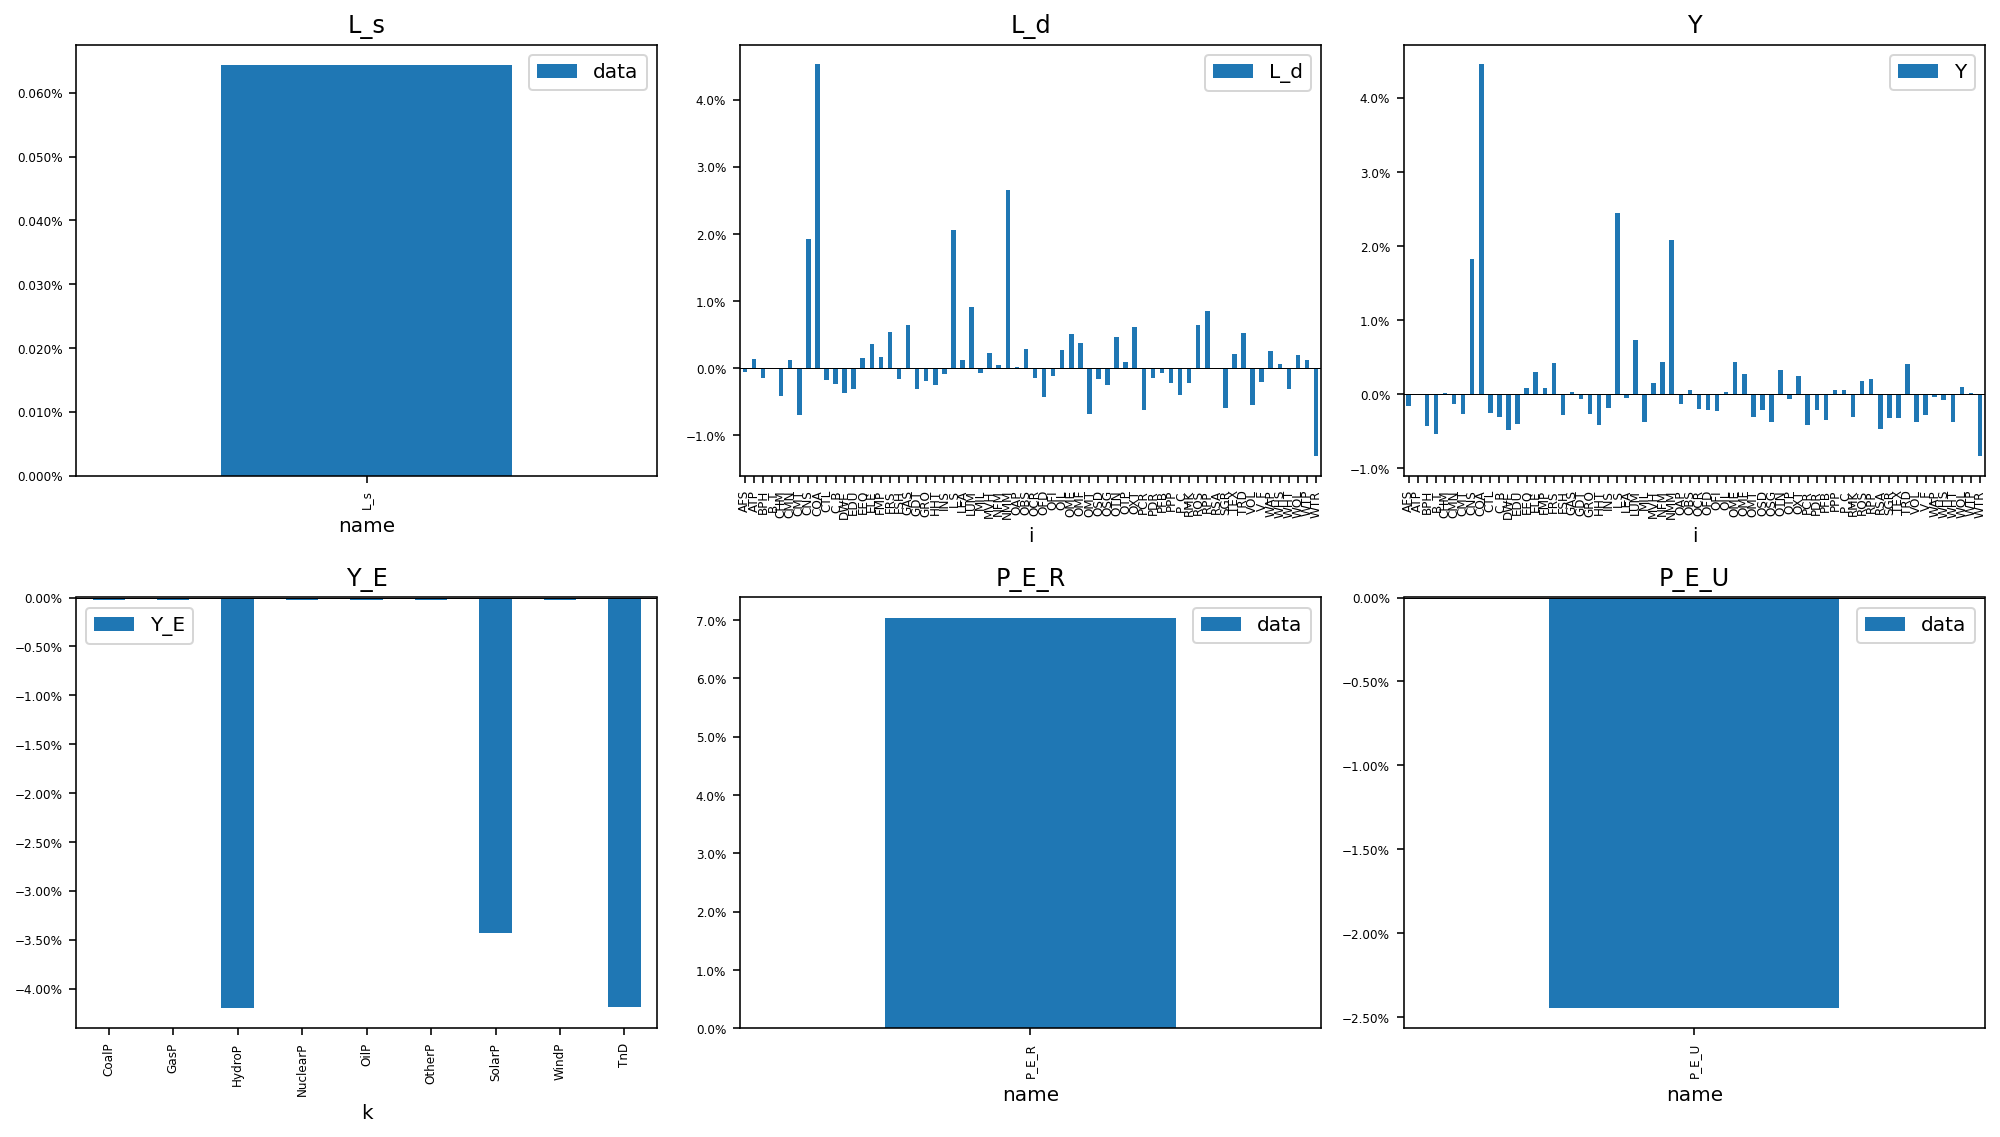

In [31]:
fig = cgp.plot_bar(
    res_alb,
    mod,
    ["L_s", "L_d", 'Y', 'Y_E', 'P_E_R', 'P_E_U'],
    plot_together=False,
    figsize=(14, 8),
    dpi=144,
    orientation="v",
    metric="pct_change",
)

fig.tight_layout()
plt.show()

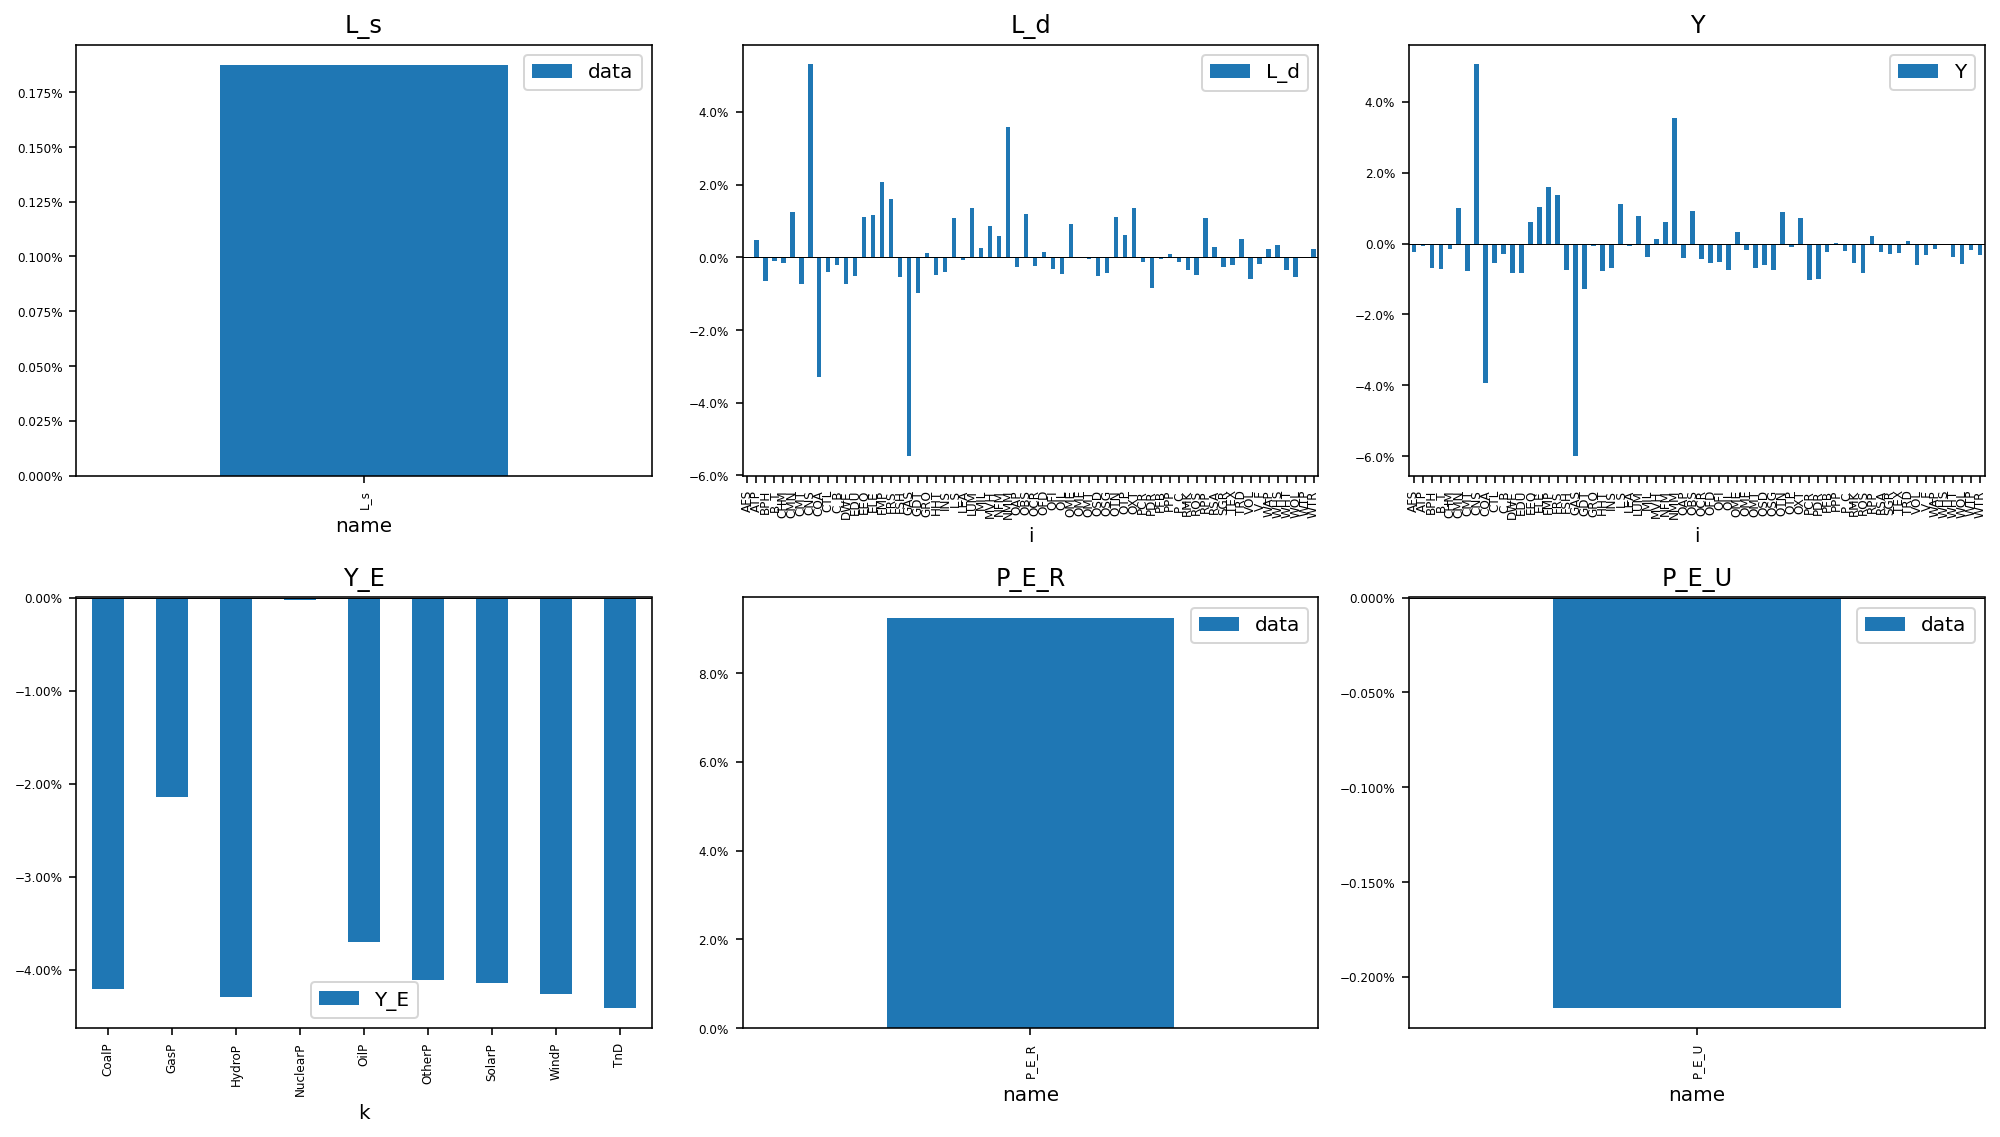

In [23]:
fig = cgp.plot_bar(
    res,
    mod,
    ["L_s", "L_d", 'Y', 'Y_E', 'P_E_R', 'P_E_U'],
    plot_together=False,
    figsize=(14, 8),
    dpi=144,
    orientation="v",
    metric="pct_change",
)

fig.tight_layout()
plt.show()

In [19]:
energy_intensity = initial_data['factor_demand'].iloc[-2:, :].sum(axis=0) / initial_data['factor_demand'].sum(axis=0)
energy_intensity.name = 'energy_intensity'

In [20]:
is_regulated = initial_data['factor_demand'].loc['Regulated Electricity'] > 1e-4

In [21]:
import seaborn as sns

In [35]:
import cloudpickle
with open('srb_shock_full_100_steps.p', 'rb') as file:
    res = cloudpickle.load(file)

In [56]:
start_sum = res['euler'].variables.isel(step=0).sum(dim=['i'])[['K_d', 'L_d', 'Y']]
end_sum = res['euler'].variables.isel(step=-1).sum(dim=['i'])[['K_d', 'L_d', 'Y']]

In [40]:
var_names = ['K_d', 'L_d', 'Y']
start =  res['euler'].isel(step=0).variables[var_names].to_dataframe()[var_names]
end = res['euler'].isel(step=-1).variables[var_names].to_dataframe()[var_names]
pct_change = (end - start) / start

In [57]:
end_sum - start_sum

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    K_d      float64 8B 241.0
    L_d      float64 8B 337.8
    Y        float64 8B 1.542e+03

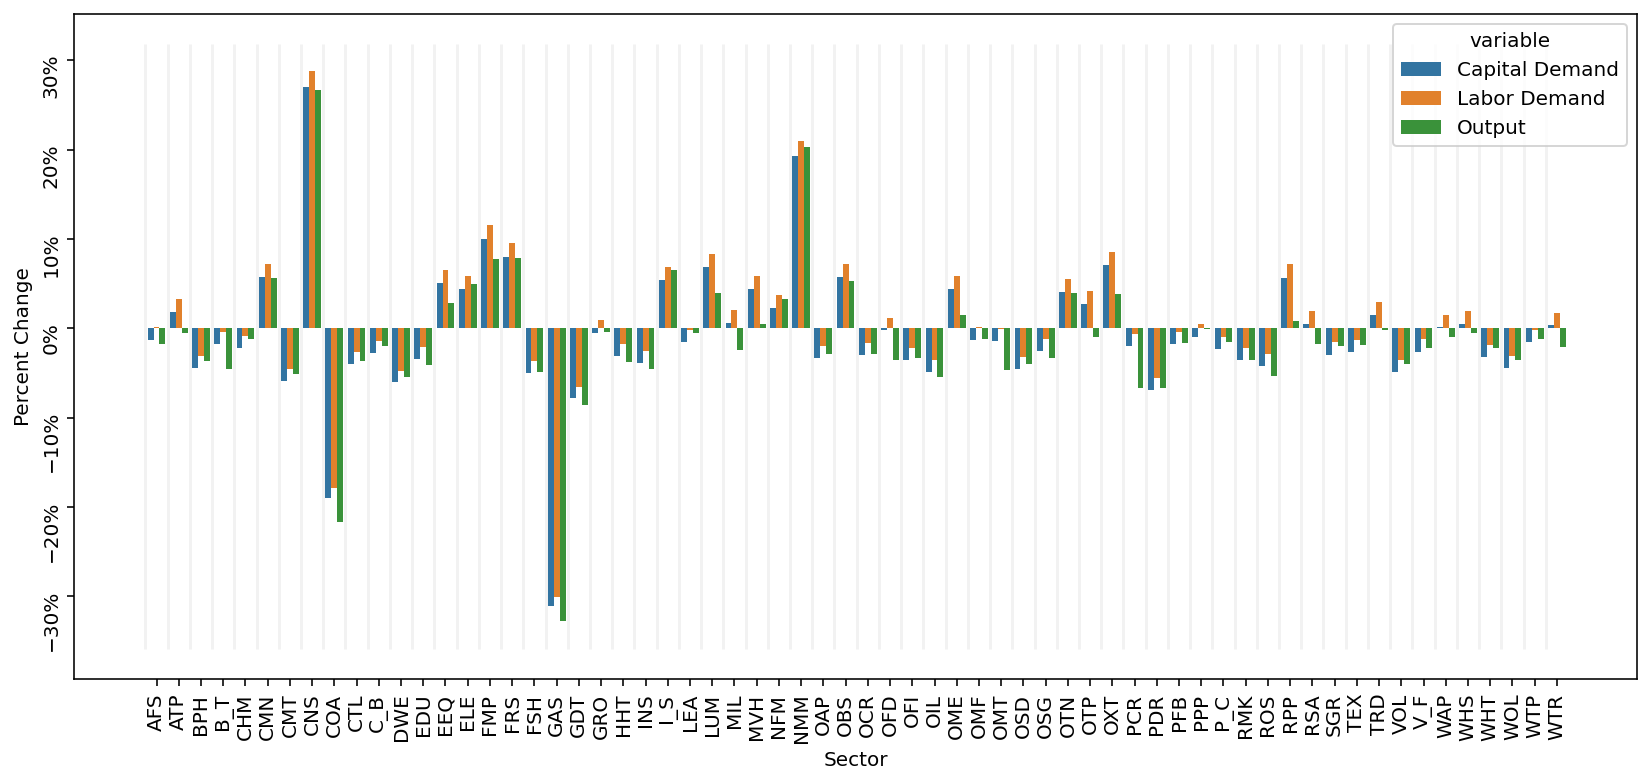

In [55]:
import seaborn as sns
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(14, 6), dpi=144, sharex=True)

sns.barplot(pct_change.rename(columns={'K_d':'Capital Demand', 'L_d':'Labor Demand', 'Y':'Output'}).melt(ignore_index=False, value_name='Percent Change').reset_index().rename(columns={'i':'Sector'}),
            x='Sector',
            y='Percent Change',
            hue='variable',
            ax=ax)
ylims = ax.get_ylim()
xlims = ax.get_xlim()
x_grid = np.arange(*xlims)
# mask = np.array([True, False] * (len(coords['i']) // 2)) # + [True])
# ax.fill_between(x_grid, *ylims, where = mask, alpha=0.1, color='0.5')
ax.vlines(x_grid, *ylims, alpha=0.1, color='0.5')
ax.tick_params(rotation=90)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

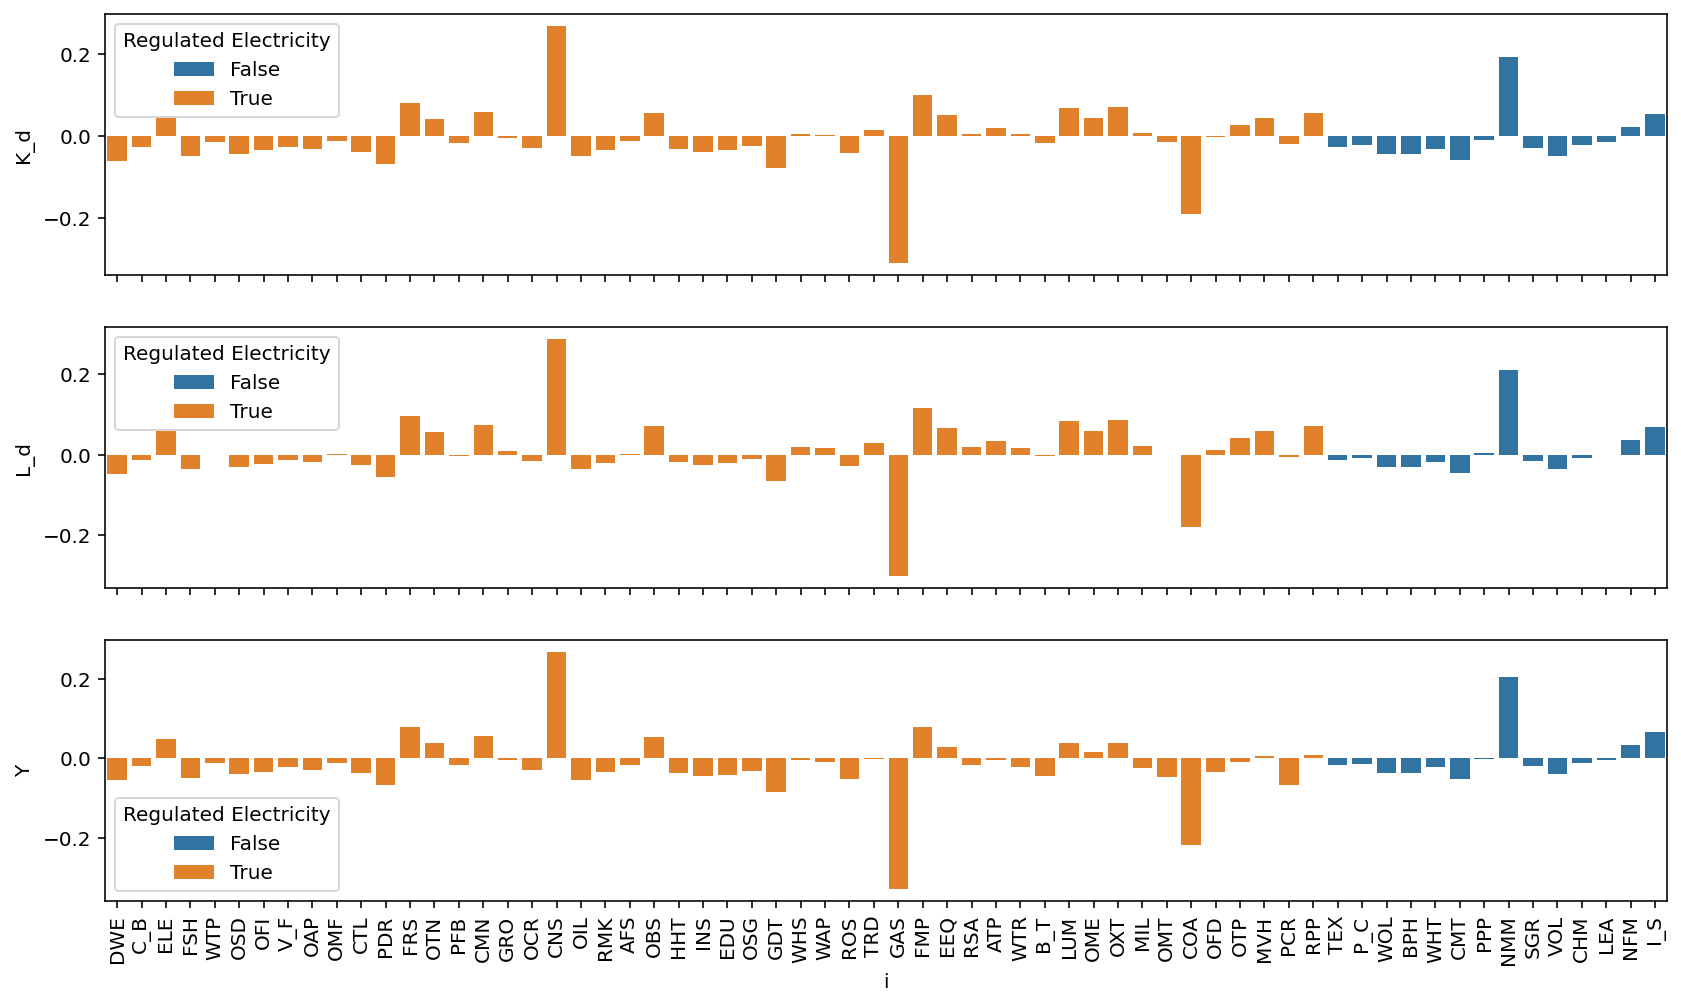

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8), dpi=144, sharex=True)


for axis, var in zip(fig.axes, ['K_d', 'L_d', 'Y']):
    labor_start = res['euler'].isel(step=0).variables[var].to_dataframe()[var]
    labor_end = res['euler'].isel(step=-1).variables[var].to_dataframe()[var]
    labor_change = (labor_end - labor_start) / labor_start
    sns.barplot((labor_change
         .to_frame()
         .join(energy_intensity)
         .join(is_regulated)
         .sort_values(by='energy_intensity')
         .reset_index()),
                y=var,
                x='i',
                hue='Regulated Electricity',
                ax=axis
    )
    axis.tick_params(axis='x', rotation=90)
plt.show()

In [ ]:
fig = cgp.plot_bar(
    res,
    mod,
    ["L_s", "L_d", 'Y'],
    plot_together=False,
    figsize=(14, 4),
    dpi=144,
    orientation="v",
    metric="pct_change",
)

fig.tight_layout()
plt.show()

In [ ]:
fig = cgp.plot_lines(
    res,
    mod,
    plot_optimizer=False,
    var_names=["K_d", "L_d", 'Y'],
    figsize=(14, 4),
    dpi=144,
)

fig.tight_layout()
plt.show()

In [ ]:
(initial_data['factor_demand'].loc['Electricity'] / initial_data['factor_demand'].sum(axis=0)).sort_values().plot.bar(figsize=(14, 4))

In [ ]:
import cge_modeling.plotting as cgp
from importlib import reload
cgp = reload(cgp)

In [ ]:
cgp.plot_kateplot(res, calibrated_data, mod, var_names=['Y_E'], cmap='Dark2', pad=1);

In [ ]:
# from cge_modeling.plotting import plot_lines

# cgp.plot_lines(
#     res,
#     mod,
#     n_cols=4,
#     var_names=["Y_E", "E_s", "Y", "C_D", "E_H_d", "L_s", "P_E", "E_d"],
#     figsize=(14, 9),
#     dpi=144,
#     legends=["Y_E"],
#     rename_dict={
#         "Y_E": "Production of Energy",
#         "E_s": "Supply of electricity",
#         "Y": "Production of Goods",
#         "C_D": "Household consumption of domestic goods",
#         "E_H_d": "Household consumption of electricity",
#         "L_s": "Household supply of labor",
#         "P_E": "Price of electricity",
#         "E_d": "Firm demand for electricity",
#     },
#     cmap="tab20",
#     plot_optimizer=False
# );